# NREL - NSRDB Multi-year Means HSDS Example

This notebook demonstrates data export from the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit and National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

You can also add the above contents to a configuration file at ~/.hscfg

In [ ]:
%matplotlib inline
import h5pyd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import time

# Plotting settings
mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16)
mpl.rc('font', size=16)

## NSRDB on AWS (via HSDS)

In [2]:
file_path = '/nrel/nsrdb/v3/nsrdb_2017.h5'
with h5pyd.File(file_path, mode='r') as f:
    meta = pd.DataFrame(f['meta'][...])
    
meta.head()

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover
0,-19.99,-175.259995,0.0,13,b'None',b'None',b'None',b'None',-9999,210
1,-19.99,-175.220001,0.0,13,b'None',b'None',b'None',b'None',-9999,210
2,-19.99,-175.179993,0.0,13,b'None',b'None',b'None',b'None',-9999,210
3,-19.99,-175.139999,0.0,13,b'None',b'None',b'None',b'None',-9999,210
4,-19.99,-175.100006,0.0,13,b'None',b'None',b'None',b'None',-9999,210


## Compute Multi-year GHI means for California

In [56]:
ca_meta = meta.loc[meta['state'] == b'California']
ca_pos = ca_meta.index.values.copy()
ca_slice = slice(ca_pos[0], ca_pos[-1] + 1)
ca_pos -= ca_pos[0]
down_size = 17520 * len(ca_pos) * 2 * 10**-6
ca_meta.head()
print('Number of NSRDB pixels in CA = {}'.format(len(ca_meta)))
print('Download size per year = {:.4f} MB'.format(down_size))

Number of NSRDB pixels in CA = 26010
Download size per year = 911.3904 MB


In [10]:
ca_df = ca_meta[['latitude', 'longitude']].copy()
ext_time = {}
ts = time.time()
for year in range(1998, 2018):
    col = '{}_means'.format(year)
    ty = time.time()
    file_path = '/nrel/nsrdb/nsrdb_{}.h5'.format(year)
    with h5pyd.File(file_path, mode='r') as f:
        ghi = f['ghi'][:, ca_slice]
    
    ca_df[col] = np.mean(ghi[:, ca_pos], axis=0)
    tt = time.time() - ty
    ext_time[str(year)] = tt
    print('Means for {} computed in {:.4f} minutes'.format(year, tt / 60))
    
tt = time.time() - ts
ext_time['total'] = tt
print('Time to extract all means =  {:.4f} hours'.format(tt / 3600))

Means for 1998 computed in 2.4272 minutes
Means for 1999 computed in 2.3108 minutes
Means for 2000 computed in 2.8610 minutes
Means for 2001 computed in 2.1860 minutes
Means for 2002 computed in 2.8931 minutes
Means for 2003 computed in 2.1646 minutes
Means for 2004 computed in 2.0560 minutes
Means for 2005 computed in 2.5468 minutes
Means for 2006 computed in 3.0375 minutes
Means for 2007 computed in 2.1168 minutes
Means for 2008 computed in 2.2137 minutes
Means for 2009 computed in 2.4636 minutes
Means for 2010 computed in 3.0267 minutes
Means for 2011 computed in 3.6068 minutes
Means for 2012 computed in 3.4656 minutes
Means for 2013 computed in 1.9683 minutes
Means for 2014 computed in 1.9381 minutes
Means for 2015 computed in 3.4000 minutes
Means for 2016 computed in 11.2320 minutes
Means for 2017 computed in 10.3944 minutes
Time to extract all means =  1.1385 hours


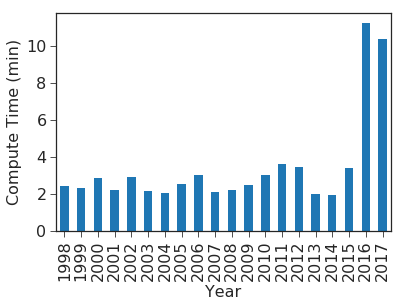

In [66]:
ext_df = pd.DataFrame(ext_time, index=['seconds']).T
ext_df['minutes'] = ext_df['seconds'] / 60
ext_df['hours'] = ext_df['seconds'] / 3600
ax = ext_df.iloc[:-1]['minutes'].plot.bar()
ax.set_xlabel('Year')
ax.set_ylabel('Compute Time (min)')
plt.show()

In [69]:
means_cols = [col for col in ca_df.columns
              if 'means' in col]
ca_df['MY means'] = ca_df[means_cols].mean(axis=1)
ca_df['CV'] = ca_df[means_cols].std(axis=1) / ca_df['MY means']
ca_df.head()

,latitude,longitude,1998_means,1999_means,2000_means,2001_means,2002_means,2003_means,2004_means,2005_means,...,2011_means,2012_means,2013_means,2014_means,2015_means,2016_means,2017_means,MY_means,CV,MY means
70276,32.529999,-117.099998,226.297089,227.499258,227.814435,219.323801,228.692694,223.069121,234.480704,228.939155,...,230.957934,220.826275,222.841952,236.375742,227.726598,223.735770,219.384703,227.464310,0.022628,227.464310
70588,32.570000,-117.099998,225.614212,227.040925,227.135189,218.695719,228.264212,221.385674,233.810849,228.355651,...,226.990468,224.872325,227.944749,237.830651,228.692409,229.352914,224.015068,227.484729,0.020598,227.484729
70589,32.570000,-117.059998,223.525228,228.518664,228.474727,221.197374,230.869977,222.071233,233.729907,226.261986,...,229.870548,227.043374,230.237500,239.100799,228.582021,228.933686,225.387671,228.386082,0.019468,228.386082
70590,32.570000,-117.019997,223.234589,233.281507,231.484688,225.171347,234.743664,225.573973,237.253700,229.289155,...,236.024087,232.472905,234.445320,241.093950,230.722260,232.822461,228.992295,232.101620,0.019550,232.101620
70591,32.570000,-116.980003,223.770263,233.775228,232.040016,226.190297,235.497774,226.582705,237.993682,229.940811,...,237.192180,232.592896,235.110959,241.873231,231.242808,233.174408,228.989555,232.725752,0.019419,232.725752


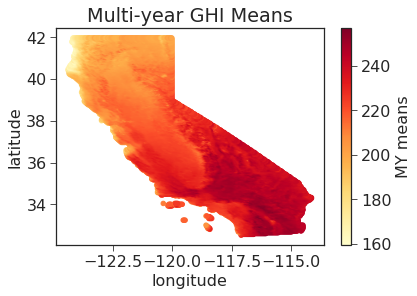

In [70]:
ax = ca_df.plot.scatter(x='longitude', y='latitude', c='MY means',
                colormap='YlOrRd',
                title='Multi-year GHI Means')
plt.show()

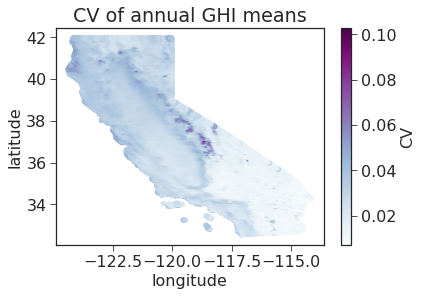

In [68]:
ca_df.plot.scatter(x='longitude', y='latitude', c='CV',
                colormap='BuPu',
                title='CV of annual GHI means')
plt.show()